# Interpretability methods against a CNN trained on MNIST

In this *jupyter notebook* we try to use various interpretability methods to try to explain how a C-NN trained on *MNIST* behaves. <br>

The methods used are:
1. Home made
2. Captum (https://github.com/pytorch/captum)
3. Shap (https://github.com/slundberg/shap)

### 1. Inital settings

In [1]:
import os
import time
from tqdm import tqdm

import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import cv2

import captum
import shap

from torch import nn, optim
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score

from src.dataset import MNIST3D
from src.models import MnistNet
from src.explainers import GradCam
from src.utils import MidpointNormalize

In [2]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam
)

### 2. Load the data

We use the custom class to load the MNIST dataset, divided in bacth size

In [3]:
mnist = MNIST3D(root='data')
trainset, testset = mnist.get_dataloader(batch_size=10000, num_workers=0)

### 3. Load the model

This cell will load the model and load the parameters with the ones of a saved and pre trained model.<br>
We display the model architecure and its validation results.

**N.B**<br>
We use *cuda* as device

In [4]:
device = torch.device('cuda')
net = MnistNet(in_channels=3, pre_trained_weights='models/mnist3d_params.pth').to(device)
net.eval()
loss_fn = nn.CrossEntropyLoss()
loss, accuracy = net.eval_step(testset, loss_fn, device)
print('____________ARCHITECTURE____________')
print(net, end='\n\n')
print('_______________RESULTS______________')
print('Evaluation loss:\t{:.4f}\nAccuracy score:\t\t{:.4f}'.format(loss, accuracy))

____________ARCHITECTURE____________
MnistNet(
  (FeatureExtractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(20, 24, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (Classifier): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1944, out_features=256, bias=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

_______________RESULTS______________
Evaluation loss:	0.0792
Accuracy score:		0.9751


### 4. Choose Example

Here we get an example from the validation set to run our tests. We display the example togheter with the model output (both raw output and softmax output)

Raw output:
	tensor([-1.8412, -3.8900,  1.5446,  2.6329, -8.3153, -2.8631, -7.5748, 13.5545,
        -3.6157,  1.1668], device='cuda:0')
Probability:
	tensor([2.0594e-07, 2.6542e-08, 6.0834e-06, 1.8063e-05, 3.1774e-10, 7.4118e-08,
        6.6623e-10, 9.9997e-01, 3.4918e-08, 4.1695e-06], device='cuda:0')


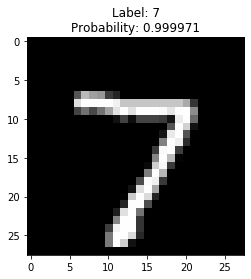

In [5]:
X, y = mnist.get_examples(testset, example_number = 0, n_examples = 1)
X = X.view(3, 28, 28)

raw_output = net(X.view(1, 3, 28, 28).to(device))
probs = nn.Softmax(dim=1)(raw_output)[0]
print('Raw output:\n\t{}'.format(raw_output[0].data))
print('Probability:\n\t{}'.format(probs.data))

plt.imshow(np.transpose(X.cpu().numpy(), (1, 2, 0)))
plt.title('Label: {}\nProbability: {:.6f}'.format(int(y), float(probs[y])))
plt.show()

In [6]:
for batch in testset:
    data, label = batch[0].to(device), batch[1]
    data = data.expand((-1, 3, 28, 28))
    break
    
to_explain = data[[105, 234, 3044]]

### 5. Evaluate methods
#### 5._) Captum - DeepLift

Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


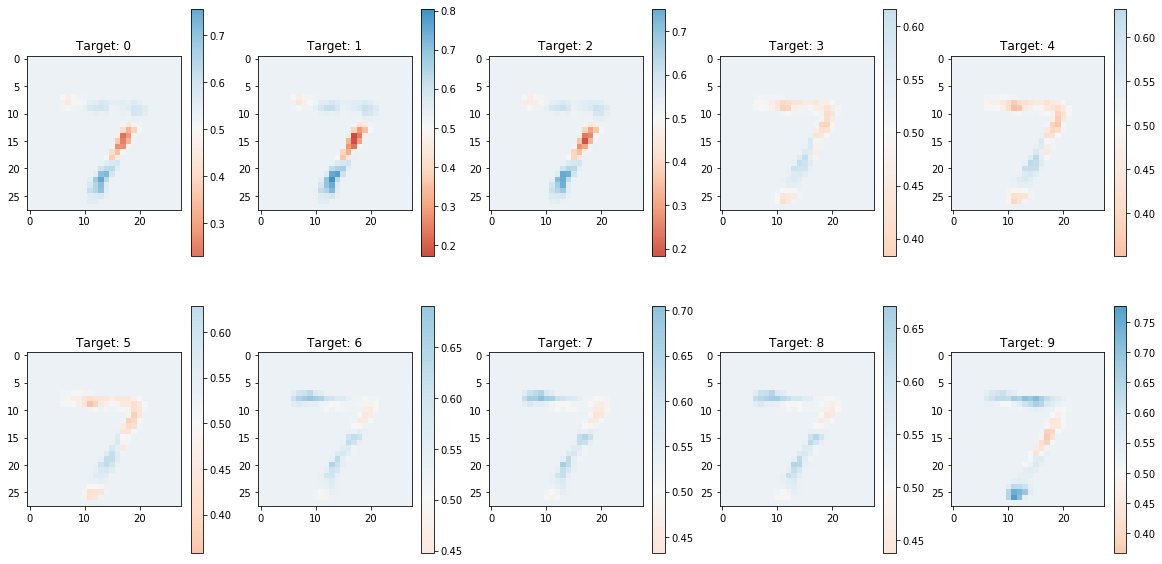

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

dl = DeepLift(net)
baseline = torch.zeros((1, 3, 28, 28)).to(device)

results = torch.Tensor([])
deltas = []
for n in range(10):
    output, delta = dl.attribute(X.view(1, *X.size()).to(device), baseline, n, return_convergence_delta=True)
    deltas.append(float(delta))
    results = torch.cat((results, output.view(3, 28, 28).detach().cpu()))
    
dl_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))

for n in range(10):
    img_input = dl_results[n].numpy()
    vmean = np.mean([np.min(img_input), np.max(img_input)])
    normalizer = MidpointNormalize(vmin = np.min(img_input), vmax = np.max(img_input), vcenter = vmean)
    
    img = ax[n//5, n%5].imshow(img_input, cmap=plt.cm.RdBu, norm=normalizer)
    plt.colorbar(img, ax=ax[n//5, n%5])
    ax[n//5, n%5].set_title('Target: ' + str(n))
plt.show()


#### 5._) GradCam

We use the custom class *GradCam* with three different option for output type (*relu, idendity, absolute value*).

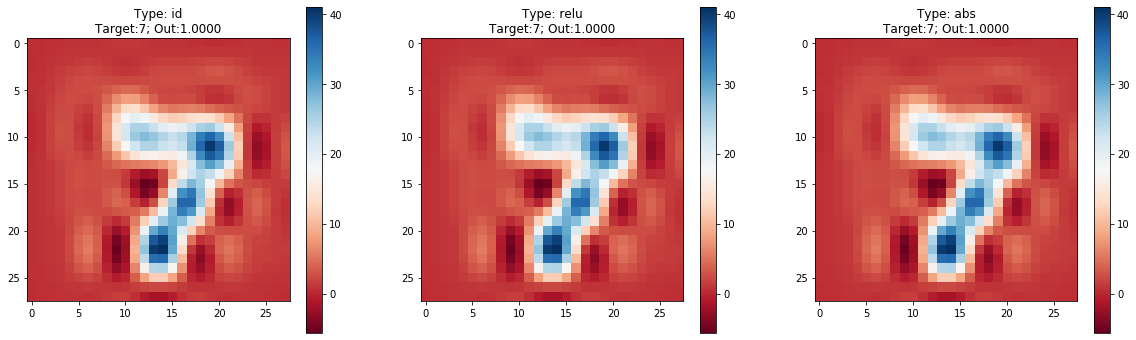

In [8]:
grad_cam = GradCam(net, net.FeatureExtractor[-2], device)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
out_types = ['id', 'relu', 'abs']
for n, out_type in enumerate(out_types):
    grad_cam_output = grad_cam(X, y, out_type=out_type, interpolation_mode = cv2.INTER_LANCZOS4)
    img = ax[n].imshow(grad_cam_output, cmap=plt.cm.RdBu)
    plt.colorbar(img, ax=ax[n])
    ax[n].set_title('Type: {}\nTarget:{}; Out:{:.4f}'.format(out_type, int(y), float(probs[y])))
plt.show()

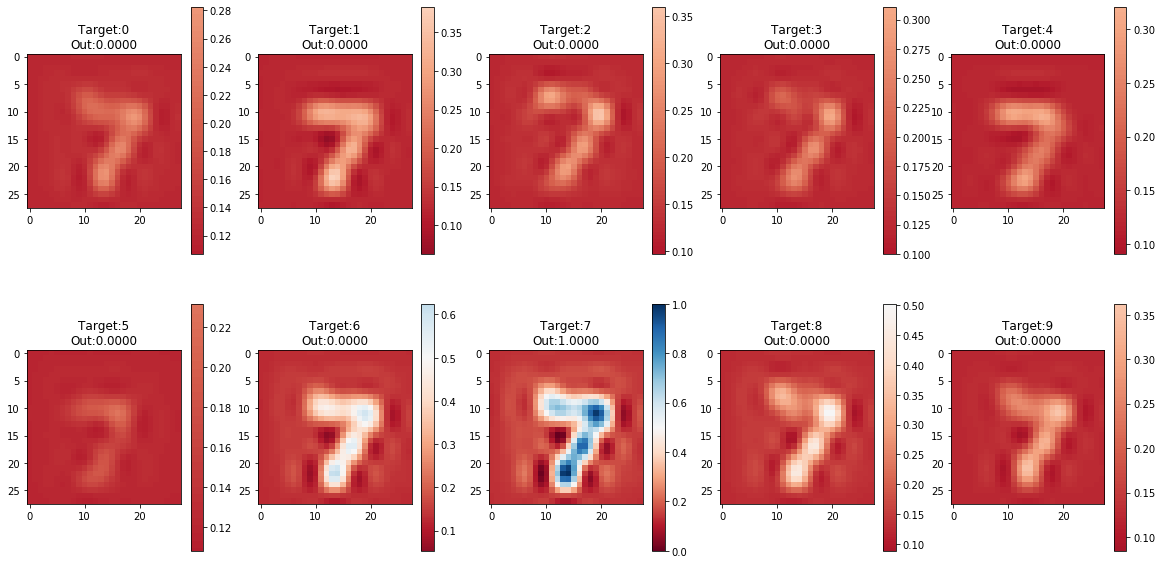

In [9]:
grad_cam = GradCam(net, net.FeatureExtractor[-2], device)
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
results = torch.Tensor([])

for n in range(10):
    out = grad_cam(X, n, out_type='abs')
    results = torch.cat([results, out.view(1, 28, 28)])

gc_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))
for n in range(10):
    img_input = gc_results[n].numpy()
    vmean = np.mean([np.min(img_input), np.max(img_input)])
    normalizer = MidpointNormalize(vmin = np.min(img_input), vmax = np.max(img_input), vcenter = vmean)
    img = ax[n//5, n%5].imshow(img_input, cmap=plt.cm.RdBu, norm=normalizer)
    plt.colorbar(img, ax=ax[n//5, n%5])
    ax[n//5, n%5].set_title('Target:{}\nOut:{:.4f}'.format(n, float(probs[n])))

#### 5._) Shap - GradientShap

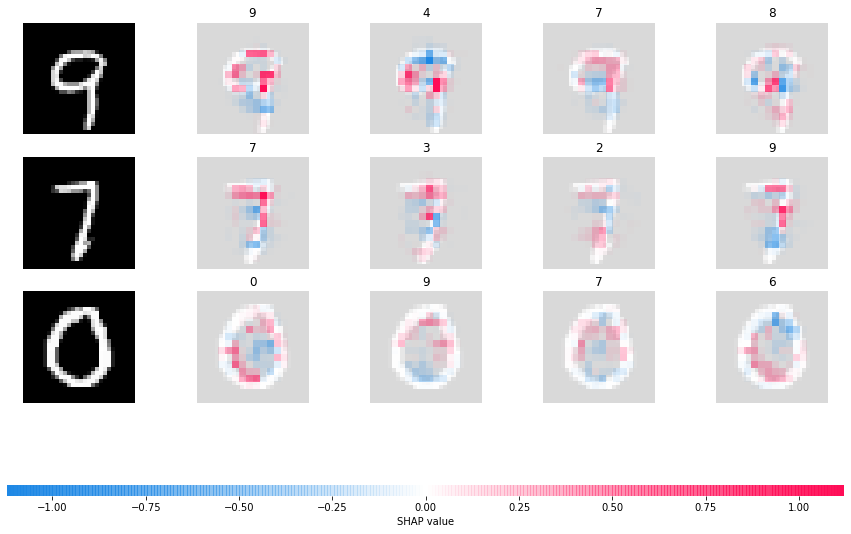

In [10]:
e = shap.GradientExplainer((net, net.FeatureExtractor[-2]), data)
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=4, nsamples=200)
# get the names for the classes
index_names = np.vectorize(lambda x: str(x))(indexes.cpu())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, np.transpose(to_explain.cpu().numpy(), (0, 2, 3, 1)), index_names)

#### 5._) Shap - DeepShap

In [31]:
background = data[9000:9500]
e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(to_explain)

-0.06204104796051979 0.12276918441057205
0.0 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


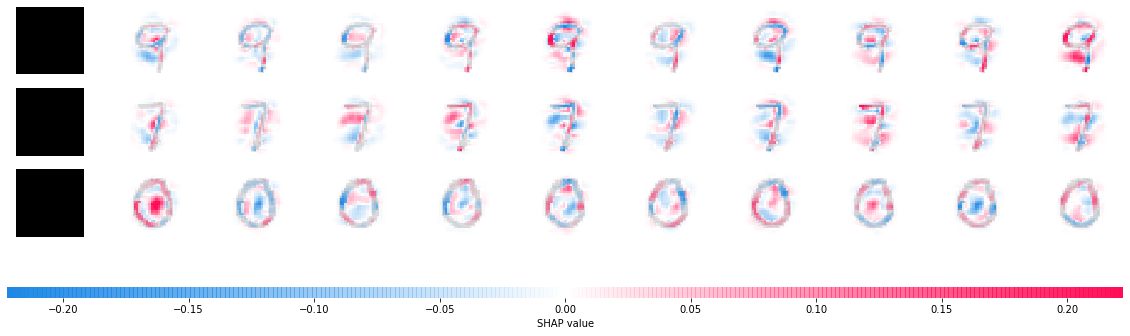

In [32]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(to_explain.cpu().numpy(), 1, -1), 1, 2)
print(shap_numpy[0].min(), shap_numpy[0].max())
print(test_numpy.min(), test_numpy.max())
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(to_explain.cpu().numpy(), 1, -1), 1, 2)

print(shap_numpy[0].min(), shap_numpy[0].max())
print(test_numpy.min(), test_numpy.max())
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)